In [1]:
import numpy as np 
import pandas as pd
import os


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/MaskNoMask.zip

In [7]:
import os
print(os.listdir("/content/Dataset"))


['with_mask', 'mask_weared_incorrect', 'without_mask']


In [8]:
img_dir='/content/Dataset'

In [9]:
train_transforms = transforms.Compose([transforms.Resize((120, 120)),
                                       transforms.ColorJitter(0.05),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                     ])

In [10]:
train_set = datasets.ImageFolder(img_dir, transform=train_transforms)

In [11]:
test_size = 0.2

num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)

test_split = int(np.floor((test_size) * num_train))
test_index, train_index = indices[:test_split - 1], indices[test_split - 1:]

train_sampler = SubsetRandomSampler(train_index)
test_sampler = SubsetRandomSampler(test_index)

train_loader = DataLoader(train_set, sampler=train_sampler, batch_size=104)
test_loader = DataLoader(train_set, sampler=test_sampler, batch_size=58)
print("Images in Test set: {}\nImages in Train set: {}".format(len(test_index), len(train_index)))

Images in Test set: 1795
Images in Train set: 7187


In [17]:
classes=['semi_mask','mask','no_mask']


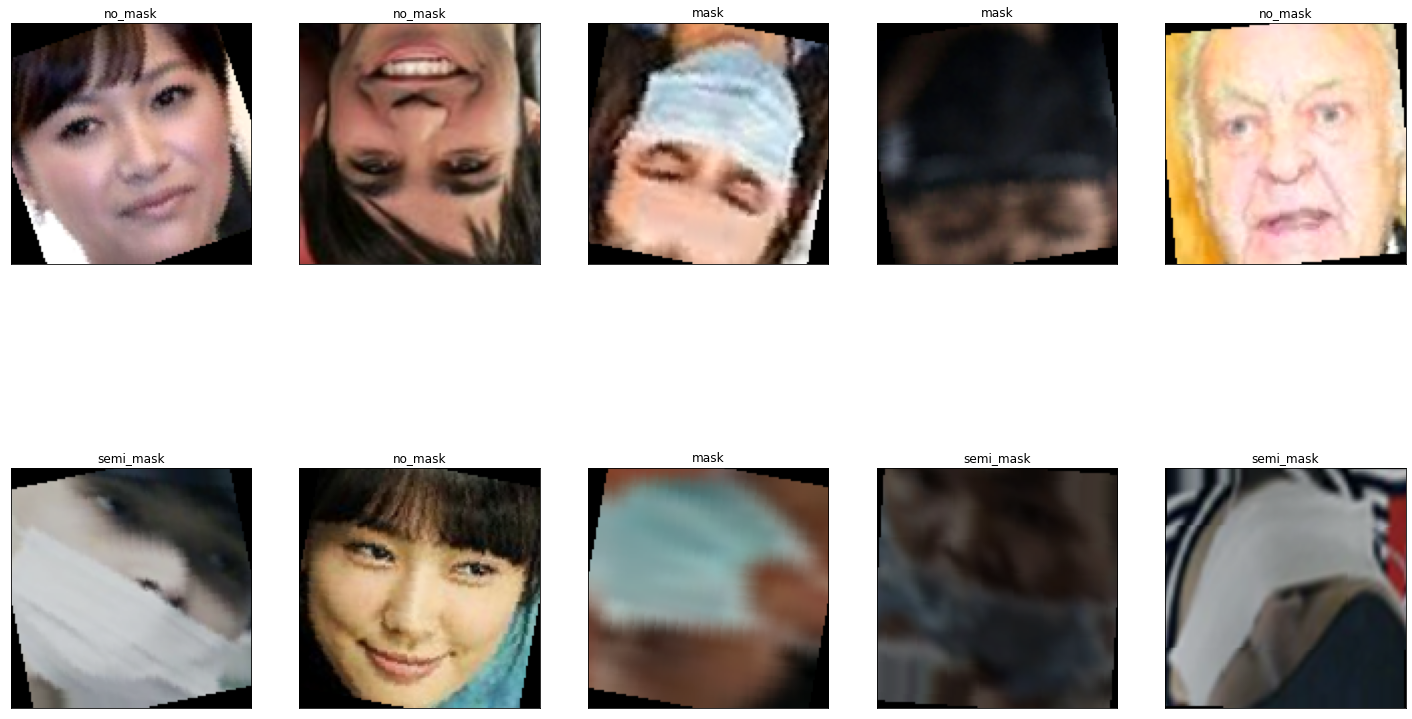

In [18]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(25, 15))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[], title=classes[labels[i]])
    imshow(images[i])
plt.show()

In [19]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([104, 3, 120, 120])
torch.Size([3, 120, 120])
1


In [20]:
num_classes = 3

In [24]:
from torchvision import models

In [25]:
resnet18 = models.resnet18()

In [26]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
in_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(in_features, num_classes)

In [28]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
def evaluation(dataloader, model):
  total, correct = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred==labels).sum().item()
  return 100 * correct/ total

In [30]:
resnet18 = resnet18.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet18.parameters(), lr=0.005, momentum=0.9)

In [31]:
import copy

In [32]:
len(train_loader)

70

Min loss 1.13
Iteration: 0/70, Loss: 1.13
Min loss 1.05
Min loss 1.00
Min loss 0.89
Min loss 0.85
Min loss 0.75
Min loss 0.72
Min loss 0.58
Min loss 0.53
Min loss 0.47
Min loss 0.42
Min loss 0.40
Min loss 0.35
Min loss 0.22
Epoch: 0/20, Test acc: 80.50, Train acc: 81.33
Iteration: 0/70, Loss: 0.48
Min loss 0.22
Min loss 0.16
Epoch: 1/20, Test acc: 87.58, Train acc: 88.70
Iteration: 0/70, Loss: 0.26
Min loss 0.15
Min loss 0.14
Min loss 0.13
Epoch: 2/20, Test acc: 91.53, Train acc: 92.83
Iteration: 0/70, Loss: 0.24
Min loss 0.11
Min loss 0.10
Min loss 0.07
Epoch: 3/20, Test acc: 93.09, Train acc: 94.55
Iteration: 0/70, Loss: 0.13
Min loss 0.07
Min loss 0.07
Min loss 0.06
Min loss 0.06
Epoch: 4/20, Test acc: 94.65, Train acc: 95.38
Iteration: 0/70, Loss: 0.12
Min loss 0.04
Epoch: 5/20, Test acc: 93.54, Train acc: 95.94
Min loss 0.04
Iteration: 0/70, Loss: 0.04
Min loss 0.04
Min loss 0.01
Epoch: 6/20, Test acc: 95.15, Train acc: 96.93
Iteration: 0/70, Loss: 0.03
Epoch: 7/20, Test acc: 95.4

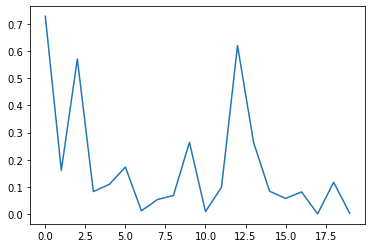

In [33]:
loss_epoch_arr = []
max_epochs = 20

min_loss = 1000

n_iters = len(train_loader)

for epoch in range(max_epochs):

  for i, data in enumerate(train_loader, 0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = resnet18(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    if min_loss > loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(resnet18.state_dict())
      print('Min loss %0.2f' % min_loss)

    if i % 100 == 0:
      print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))

    del inputs, labels, outputs
    torch.cuda.empty_cache()

  loss_epoch_arr.append(loss.item())

  print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
      epoch, max_epochs,
      evaluation(test_loader, resnet18), evaluation(train_loader, resnet18)
  ))

plt.plot(loss_epoch_arr)
plt.show()

In [34]:
print('Test acc: %0.2f, Train acc: %0.2f' % (evaluation(test_loader,resnet18), evaluation(train_loader,resnet18)))

Test acc: 97.44, Train acc: 98.91


In [35]:
torch.save(resnet18.state_dict(), "resnet18-masknomaskmodel.pt")
